# Experimenting with Package Functions

IN PROGRESS

## (1) Data generation with MOSFIT

In [ ]:
from survey_agnostic_sn_vae.data_generation.mosfit2 import *
from survey_agnostic_sn_vae.data_generation.objects import *
import os

OUTPUT_PATH = os.getcwd()

os.makedirs(OUTPUT_PATH+"/transients", exist_ok=True)

print(OUTPUT_PATH)
#for f in glob.glob(OUTPUT_PATH+"/transients/*"):
#    os.remove(f)
    
lsst_cadence = {
    'u': 25.0,
    'g': 17.0,
    'r': 6.0,
    'i': 7.0,
    'z': 8.0,
    'y': 8.0
}

panstarrs_cadence = {b: 3.0 for b in ['g', 'r', 'i', 'z']}

lsst_survey = Survey(
    'LSST',
    ['u', 'g', 'r', 'i', 'z', 'y'],
    lsst_cadence
)
ztf_survey = Survey(
    'ZTF',
    ['g', 'r'],
    2.0 # band sampling coupled
)
panstarrs_survey = Survey(
    'PanSTARRS',
    ['g', 'r', 'i', 'z'],
    panstarrs_cadence
)

generate_LCs_from_model(
    'slsn',
    [lsst_survey, ztf_survey, panstarrs_survey],
    10000,
    output_path=OUTPUT_PATH
);

/Users/kdesoto/python_repos/survey-agnostic-sn-vae/docs/notebooks
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit


In [ ]:
from survey_agnostic_sn_vae.data_generation.objects import *

OUTPUT_PATH = os.getcwd()

# Now, load Transient object
all_transient_fns = glob.glob(OUTPUT_PATH+"/transients/*")
test_transient = Transient.load(
    all_transient_fns[0],
)
print(test_transient.lightcurves) # should be 2
for lc in test_transient.lightcurves:
    print(lc.bands)
    print(lc.survey.bands)
    print(lc.survey.limiting_magnitude)

In [ ]:
import os
from survey_agnostic_sn_vae.preprocessing import (
    generate_superraenn_lc_file
)

OUTPUT_PATH = os.getcwd()

transient_dir = os.path.join(
    OUTPUT_PATH,
    "transients"
)
save_dir = os.path.join(
    OUTPUT_PATH,
    "superraenn"
)

os.makedirs(save_dir, exist_ok=True)

generate_superraenn_lc_file(
    transient_dir,
    save_dir
)

In [12]:
# overlay multiple LCs for same object 
from survey_agnostic_sn_vae.plotting import plot_lightcurves
from survey_agnostic_sn_vae.data_generation.objects import *

import os

OUTPUT_PATH = os.getcwd()

# Now, load Transient obje dct
all_transient_fns = glob.glob(OUTPUT_PATH+"/transients/*")
test_transient = Transient.load(
    all_transient_fns[1],
)

plot_lightcurves(
    test_transient,
    os.path.join(OUTPUT_PATH, "sample_transient.pdf")
)

6 6
38 38
27 27
2 2
47 47
44 44
22 22
28 28
26 26
48 48
41 41
49 49


## Test RAENN encodings

 (1) First try just VAE encodings without similarity loss

In [ ]:
from survey_agnostic_sn_vae.preprocessing import prep_input
from survey_agnostic_sn_vae.raenn import *
from tensorflow.keras.models import load_model
from survey_agnostic_sn_vae.custom_nn_layers.kl_loss import SamplingLayer
from survey_agnostic_sn_vae.custom_nn_layers.recon_loss import ReconstructionLoss
from tensorflow.keras.optimizers.legacy import Adam

OUTDIR = 'superraenn'
LCFILE = 'superraenn/lcs.npz'

NEURON_N_DEFAULT = 100
ENCODING_N_DEFAULT = 10
N_EPOCH_DEFAULT = 100

sequence, outseq, ids, maxlen, nfilts = prep_input(LCFILE, save=True, outdir=OUTDIR)
model, callbacks_list, input_1, encoded = make_model(
    NEURON_N_DEFAULT, ENCODING_N_DEFAULT, int(maxlen), nfilts, N_EPOCH_DEFAULT
)
"""
model = load_model(
    OUTDIR + "/models/trained_rubin_ps1_ztf_finetuned.h5",
    custom_objects = {
        'SamplingLayer': SamplingLayer,
        'ReconstructionLoss': ReconstructionLoss
    },
    compile=False
)
"""
new_optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)
rl = ReconstructionLoss(6)
model.compile(optimizer=new_optimizer, loss=rl)
"""
# try adding a new layer!
model, callbacks_list, input_1, encoded = add_encoded_nodes(model, N_EPOCH_DEFAULT, n=1)
ENCODING_N_DEFAULT += 1
"""
model.summary()

annealing = AnnealingCallback(model.layers[5].beta,"cyclical",N_EPOCH_DEFAULT)
callbacks_list = [annealing,]
model = fit_model(model, callbacks_list, sequence, outseq, N_EPOCH_DEFAULT)
encoder = get_encoder(model, input_1, encoded)

if OUTDIR[-1] != '/':
    OUTDIR += '/'
    
save_model(model, ENCODING_N_DEFAULT, NEURON_N_DEFAULT, outdir=OUTDIR)

save_encodings(
    model, encoder, sequence, ids, LCFILE,
    ENCODING_N_DEFAULT, NEURON_N_DEFAULT, len(ids), maxlen,
    OUTDIR
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 20)]           0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, None, 19)             0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 sequential (Sequential)     (None, 100)                  62600     ['tf.__operators__.getitem[0][
                                                                    0]']                          
                                                                                              

[0.19142937 0.64164675 0.42263565 0.         1.         0.83121735]
[[-8.90929950e+00 -1.08784501e+01  1.91429370e-01]
 [-8.90929950e+00 -1.08784501e+01  6.41646747e-01]
 [-8.90929950e+00 -1.08784501e+01  4.22635651e-01]
 ...
 [ 2.83340108e+02 -1.08784501e+01  0.00000000e+00]
 [ 2.83340108e+02 -1.08784501e+01  1.00000000e+00]
 [ 2.83340108e+02 -1.08784501e+01  8.31217345e-01]]
1/1 [==============================] - 0s 193ms/step


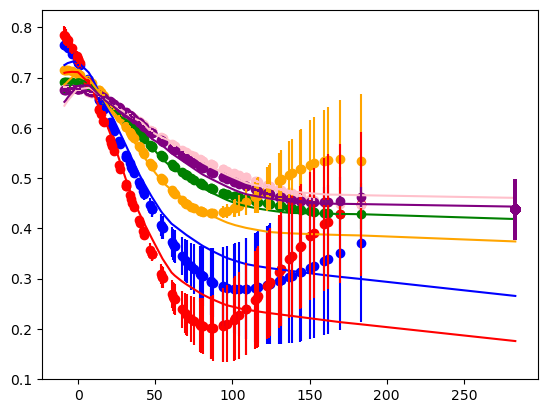

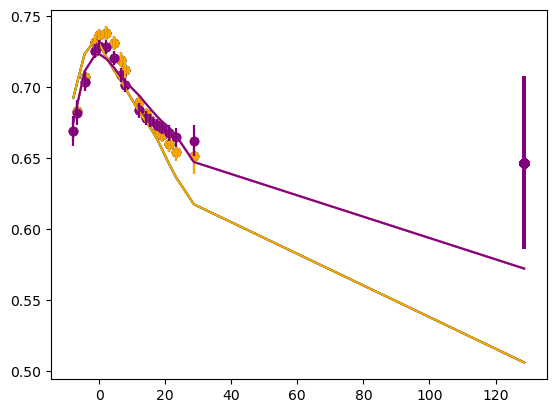

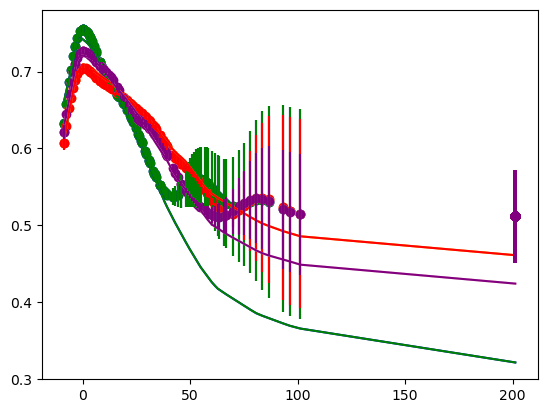

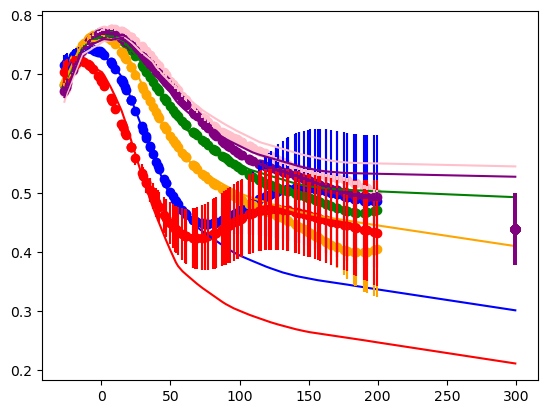

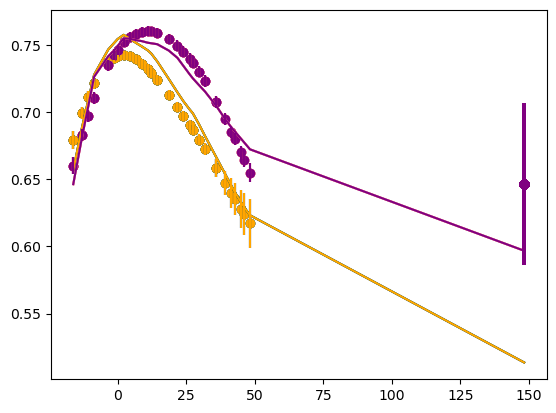

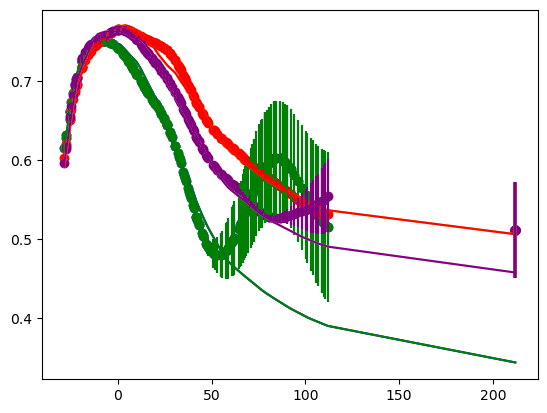

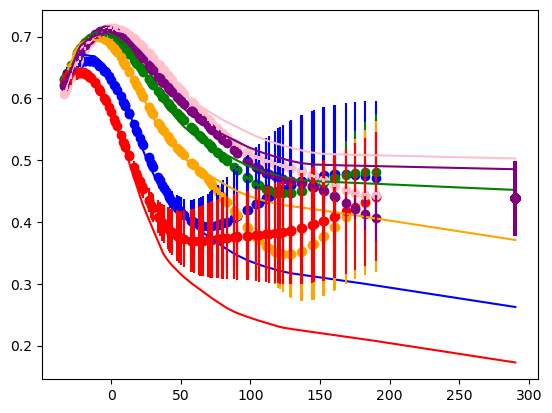

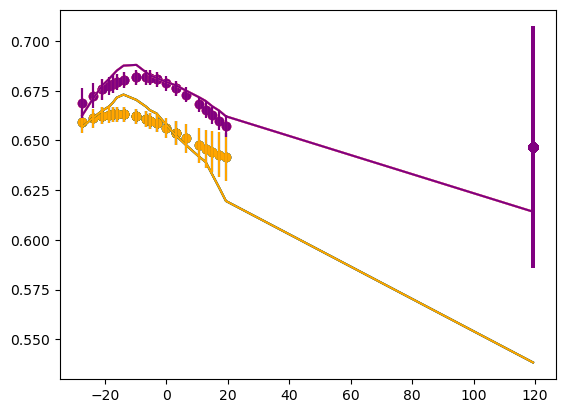

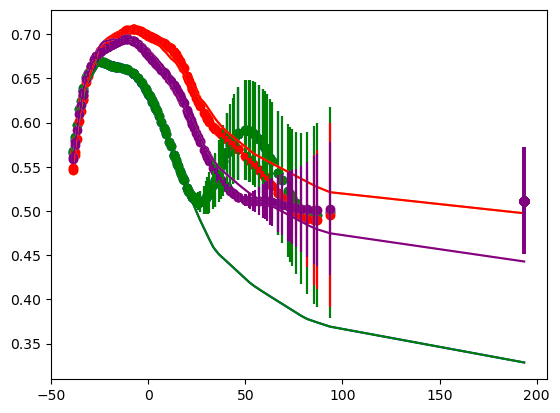

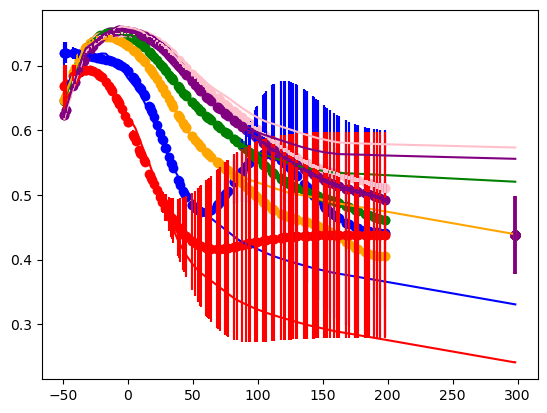

IndexError: index 10 is out of bounds for axis 0 with size 10

In [2]:
from survey_agnostic_sn_vae.preprocessing import prep_input
from survey_agnostic_sn_vae.raenn import *
from survey_agnostic_sn_vae.plotting import *

from tensorflow.keras.models import load_model
from survey_agnostic_sn_vae.custom_nn_layers.kl_loss import SamplingLayer
from survey_agnostic_sn_vae.custom_nn_layers.recon_loss import ReconstructionLoss
from tensorflow.keras.optimizers.legacy import Adam

OUTDIR = 'superraenn'
LCFILE = 'superraenn/lcs.npz'

# overlay decodings
fig, ax = plt.subplots()

model = load_model(
    OUTDIR + "/models/trained_rubin_ps1_ztf_finetuned.h5",
    custom_objects = {
        'SamplingLayer': SamplingLayer,
        'ReconstructionLoss': ReconstructionLoss
    },
    compile=False
)

sequence, outseq, ids, maxlen, nfilts = prep_input(LCFILE, save=True, outdir=OUTDIR)

decodings = get_decodings(
    model, sequence[:10], outseq[:10]
)

bands = 'ugrizy'

for i in range(20):
    seq = sequence[i]
    d = np.reshape(decodings[i], (seq.shape[0], -1))

    
    for b_idx in range(6):
        c_i = BAND_COLORS[bands[b_idx]]
        plt.errorbar(seq[:,0], seq[:,b_idx+1], yerr=seq[:,7+b_idx], fmt='none', ecolor=c_i)
        plt.scatter(seq[:,0], seq[:,b_idx+1], marker='o', color=c_i)
        plt.plot(seq[:,0], d[:,b_idx], c=c_i)
        
    plt.show()

